In [10]:
import sys
import multiprocessing as mp

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models
from torchvision.utils import make_grid

from src.utils.dataset import download_dataset, split_dataset, default_transform, get_dataloaders, image_folder_classes
from src.utils.visual import show_img, tensor_to_image, postprocess_image
from src.utils.training import fit, test_model, load_model, save_model, EarlyStopping
from src.models import Dreamnet50, Googledream, get_model
from src.deepdream import dream_process
from src.utils.config import BEETLENET_MEAN, BEETLENET_STD, get_new_config

# Set up device and workers

In [11]:
# start by setting up device
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# number of threads to handle data. bug makes ipynb hang when num > 0 on windows.
if sys.platform == "linux" or device == 'cpu':
    num_workers = mp.cpu_count()
else:
    num_workers = 0

# Import data

In [12]:
image_folder = download_dataset() + '/images/'
dataset = datasets.ImageFolder(image_folder)
train_data, val_data, test_data, dataset_sizes = split_dataset(dataset, 0.8, 0.5)
print(str(dataset_sizes))

{'train': 11118, 'val': 1390, 'test': 1390}


# Apply transforms and get dataloaders

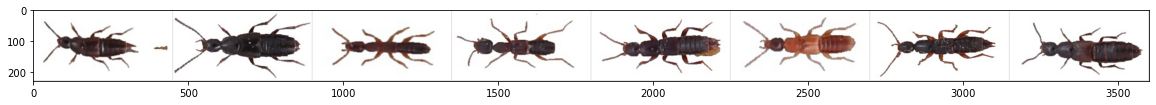

In [13]:
train_data, val_data, test_data = default_transform(train_data, val_data, test_data, shape = (224, 448), mean = BEETLENET_MEAN, std = BEETLENET_STD)
data_loaders = get_dataloaders(train_data, val_data, test_data, batch_size = 8, num_workers = num_workers)
iterable = iter(data_loaders['train'])
images, labels = next(iterable)
tensor_grid = make_grid(images, nrow=8)
image_grid = postprocess_image(tensor_to_image(tensor_grid))
show_img(image_grid, figsize=(20, 20))

# Define classification model

In [14]:
num_classes = image_folder_classes(image_folder)
model = get_model('resnet50', pretrained=True,
                  num_classes=num_classes, device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, eps=0.1)

# Train and or load classification model

In [15]:
load = True
if load == False:
    [metrics] = load_model(model, 'models/dreamnet50',get_train_metrics = True, device = device)
    print(("test accuracy = %.2f %%" % model.aux_dict['test_acc']))
else:
    metrics = fit(model, data_loaders, dataset_sizes, criterion,
                  optimizer,  EarlyStopping(), metrics_path='figures/dreamnet50', device=device)
    acc = test_model(model, data_loaders['test'])
    save_model(model, path = 'models/dreamnet50', train_metrics = metrics)
_ = model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'models/dreamnet50_aux_dict.json'

# Expose layers

In [ ]:
#dreamnet = Googledream(model)
dreamnet = Dreamnet50(model)
dreamnet.eval()
print(dreamnet.layers.keys())

dict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1_0', 'layer1_1', 'layer2_0', 'layer2_1', 'layer3_0', 'layer3_1', 'layer4_0', 'layer4_1', 'avgpool', 'fc'])


# Lets dream!

## Choose image

In [ ]:
species_name = 'achenium_humile'
example_name = '_0189_0'
image_path = image_folder + species_name + '/' + example_name + '.jpg'
print(image_path)

./data/beetles/images/achenium_humile/_0189_0.jpg


## Choose parameters and apply method

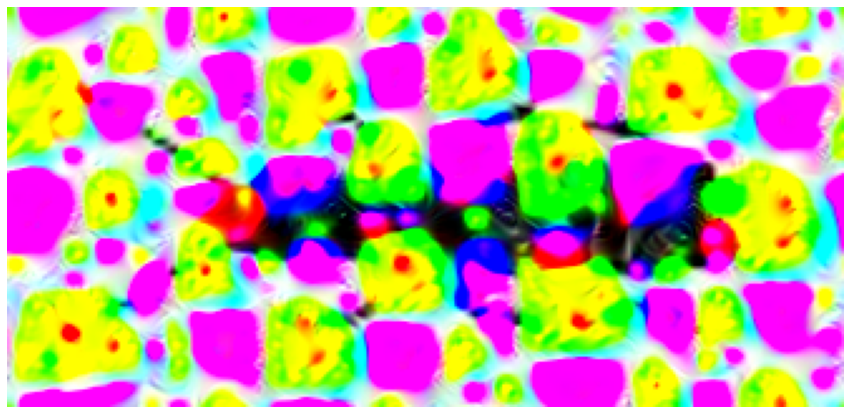

In [ ]:
params = {
    'input_img_path': image_path,
    'model': dreamnet,
    #'mean': BEETLENET_MEAN,
    #'std': BEETLENET_STD,
    'out_info': [('layer3_4', None)],
    'num_iters': 50,
    #'lr': 0.1,
    #'smooth_coef': 0,
    'device': device,
    #'noise': 'gaussian'
    'output_img_path' : 'figures/dreamt_image.jpg',
    'video_path': 'videos/dreamt_transform.gif'
}
config = get_new_config(params)

output_images = dream_process(config)
